# 🚀 FAST Feature Extraction + SVM Pipeline (< 30 minutes)

## Optimizations Applied:
1. **Skip fine-tuning**: Use pretrained features directly (saves 2+ hours)
2. **Single best aggregation**: Use only attention pooling (no need to test all)
3. **Focused classifier search**: Test only 2-3 best classifiers
4. **SMOTE for balance**: Handle class imbalance efficiently
5. **Optimized hyperparameters**: Smaller search space

Expected runtime: **20-30 minutes** vs 3+ hours

In [64]:
# FAST Feature Extraction Pipeline - Optimized for Speed
import os
import time
import torch
import joblib
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import xgboost as xgb
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# FAST Configuration - Optimized for speed
IMG_SIZE = 224
BATCH_SIZE = 32  # Larger batch for faster processing
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
FEATURES_DIR = "../../features"
MODEL_DIR = "../../models"

# Create directories
os.makedirs(FEATURES_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"   FAST Feature Extraction Pipeline")
print(f"   Device: {DEVICE}")
print(f"   Strategy: Pretrained features + SMOTE + Fast classifiers")
print(f"   Expected runtime: 20-30 minutes (vs 3+ hours)")
print(f"   Target accuracy: 65%+")

   FAST Feature Extraction Pipeline
   Device: mps
   Strategy: Pretrained features + SMOTE + Fast classifiers
   Expected runtime: 20-30 minutes (vs 3+ hours)
   Target accuracy: 65%+


In [65]:
# Fast Data Loading
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths, labels = [], []
    
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"   {species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))
    
    return file_paths, labels

# Load data quickly
print(" Loading datasets...")
train_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

# Quick validation split
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_encoded, test_size=0.2, random_state=42, stratify=train_encoded
)

print(f" Data loaded: {len(train_paths_split)} train, {len(val_paths)} val, {len(test_paths)} test")
print(f"   Classes: {list(class_names)}")

# Quick class analysis
train_counts = Counter(train_labels_split)
print(f"\n Class distribution:")
for i, name in enumerate(class_names):
    count = train_counts[i]
    print(f"   {name}: {count} samples")

 Loading datasets...
   Oak: 18 files
   Douglas Fir: 116 files
   cifar-10-batches-py: 0 files
   Spruce: 117 files
   Pine: 8 files
   Ash: 20 files
   Red Oak: 81 files
   Beech: 70 files
   Oak: 4 files
   Douglas Fir: 29 files
   cifar-10-batches-py: 0 files
   Spruce: 25 files
   Pine: 1 files
   Ash: 7 files
   Red Oak: 19 files
   Beech: 17 files
 Data loaded: 344 train, 86 val, 102 test
   Classes: [np.str_('Ash'), np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Pine'), np.str_('Red Oak'), np.str_('Spruce')]

 Class distribution:
   Ash: 16 samples
   Beech: 56 samples
   Douglas Fir: 93 samples
   Oak: 14 samples
   Pine: 6 samples
   Red Oak: 65 samples
   Spruce: 94 samples


In [66]:
# FAST Dataset - No complex augmentation
class FastTreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load multi-view images
        views = np.load(self.file_paths[idx])
        
        # Simple conversion to RGB
        rgb_images = []
        for view in views:
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            pil_img = Image.fromarray(view, mode='L').convert('RGB')
            rgb_images.append(pil_img)
        
        # Apply transforms
        if self.transform:
            rgb_images = [self.transform(img) for img in rgb_images]
        
        # Stack into tensor
        image_stack = torch.stack(rgb_images, dim=0)
        return image_stack, self.labels[idx]

# Simple transforms - no heavy augmentation
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets
train_dataset = FastTreeDataset(train_paths_split, train_labels_split, transform)
val_dataset = FastTreeDataset(val_paths, val_labels, transform)
test_dataset = FastTreeDataset(test_paths, test_encoded, transform)

print(f" Fast datasets created")

 Fast datasets created


In [67]:
# FAST Feature Extractor - Use pretrained ResNet with attention (no fine-tuning)
class FastFeatureExtractor(nn.Module):
    def __init__(self, use_attention=True):
        super(FastFeatureExtractor, self).__init__()
        
        # Use pretrained ResNet18 - NO FINE-TUNING
        self.backbone = models.resnet18(pretrained=True)
        self.feature_dim = self.backbone.fc.in_features
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Freeze all parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.use_attention = use_attention
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(self.feature_dim, self.feature_dim // 4),
                nn.ReLU(),
                nn.Linear(self.feature_dim // 4, 1),
                nn.Sigmoid()
            )
        
        print(f"    Fast Feature Extractor (ResNet18 + Attention)")
        print(f"   Feature dim: {self.feature_dim}")
        print(f"   Frozen backbone: ALL parameters")
    
    def forward(self, multi_view_batch):
        batch_size, num_views, channels, height, width = multi_view_batch.shape
        
        # Process all views
        views = multi_view_batch.view(-1, channels, height, width)
        with torch.no_grad():  # No gradients needed for frozen backbone
            features = self.backbone(views)
        features = features.view(features.size(0), -1)
        
        # Reshape to separate views
        features = features.view(batch_size, num_views, self.feature_dim)
        
        # Attention aggregation
        if self.use_attention:
            attention_weights = self.attention(features)  # (batch, views, 1)
            weighted_features = features * attention_weights
            pooled_features = torch.sum(weighted_features, dim=1)
        else:
            pooled_features = torch.mean(features, dim=1)
        
        return pooled_features

# Create FAST extractor
print(" Creating Fast Feature Extractor...")
extractor = FastFeatureExtractor(use_attention=True).to(DEVICE)

# Quick parameter count
total_params = sum(p.numel() for p in extractor.parameters())
trainable_params = sum(p.numel() for p in extractor.parameters() if p.requires_grad)
print(f"   Total params: {total_params:,}")
print(f"   Trainable params: {trainable_params:,} (only attention)")

 Creating Fast Feature Extractor...
    Fast Feature Extractor (ResNet18 + Attention)
   Feature dim: 512
   Frozen backbone: ALL parameters
   Total params: 11,242,305
   Trainable params: 65,793 (only attention)


In [68]:
# FAST Feature Extraction - No fine-tuning, just extract
def extract_features_fast(extractor, dataset, dataset_name):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    extractor.eval()
    features_list = []
    labels_list = []
    
    print(f"   Extracting {dataset_name} features...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(DEVICE)
            features = extractor(images)
            
            features_list.append(features.cpu().numpy())
            labels_list.extend(labels.numpy())
            
            if batch_idx % 10 == 0:
                print(f"      Batch {batch_idx}/{len(loader)}")
    
    features_array = np.vstack(features_list)
    labels_array = np.array(labels_list)
    
    print(f"    {dataset_name}: {features_array.shape}")
    return features_array, labels_array

# Extract features for all sets
print("⚡ Fast Feature Extraction (no fine-tuning)...")
start_time = time.time()

train_features, train_labels_arr = extract_features_fast(extractor, train_dataset, "train")
val_features, val_labels_arr = extract_features_fast(extractor, val_dataset, "val")  
test_features, test_labels_arr = extract_features_fast(extractor, test_dataset, "test")

extraction_time = time.time() - start_time
print(f" Feature extraction complete in {extraction_time:.1f}s")

# Combine train+val for final training
X_train_full = np.vstack([train_features, val_features])
y_train_full = np.hstack([train_labels_arr, val_labels_arr])

print(f" Final feature shapes:")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {test_features.shape}")

⚡ Fast Feature Extraction (no fine-tuning)...
   Extracting train features...
      Batch 0/11
      Batch 10/11
    train: (344, 512)
   Extracting val features...
      Batch 0/3
    val: (86, 512)
   Extracting test features...
      Batch 0/4
    test: (102, 512)
 Feature extraction complete in 7.7s
 Final feature shapes:
   Train: (430, 512)
   Test: (102, 512)


In [69]:
# FAST Classifier Training with SMOTE
print("⚡ FAST Classifier Training with SMOTE...")

# Apply SMOTE for class balancing
print("   Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=min(3, min(Counter(y_train_full).values())-1))

try:
    X_balanced, y_balanced = smote.fit_resample(X_train_full, y_train_full)
    print(f"    SMOTE successful: {len(y_train_full)} → {len(y_balanced)} samples")
    
    # Show balance
    balanced_counts = Counter(y_balanced)
    for i, name in enumerate(class_names):
        original = np.sum(y_train_full == i)
        balanced = balanced_counts[i]
        print(f"      {name}: {original} → {balanced}")
        
except Exception as e:
    print(f"    SMOTE failed: {e}")
    print("   Using original data...")
    X_balanced, y_balanced = X_train_full, y_train_full

# Scale features
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(test_features)

# FAST classifiers - only test the best ones
classifiers = {
    'SVM_RBF': {
        'estimator': SVC(probability=True, random_state=42),
        'params': {
            'C': [1, 10, 100],  # Reduced search space
            'gamma': ['scale', 0.01, 0.1],
            'class_weight': ['balanced']
        }
    },
    'XGBoost': {
        'estimator': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [100, 200],  # Reduced
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.2]
        }
    },
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],  # Reduced
            'max_depth': [10, 15, None],
            'class_weight': ['balanced']
        }
    }
}

# Train and evaluate quickly
results = {}
best_score = 0
best_classifier = None
best_name = ""

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced CV

for name, config in classifiers.items():
    print(f"\n🔧 Training {name}...")
    start = time.time()
    
    grid_search = GridSearchCV(
        config['estimator'], 
        config['params'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_balanced_scaled, y_balanced)
    
    # Test evaluation
    y_pred = grid_search.predict(X_test_scaled)
    test_acc = accuracy_score(test_labels_arr, y_pred)
    
    train_time = time.time() - start
    
    results[name] = {
        'classifier': grid_search.best_estimator_,
        'cv_score': grid_search.best_score_,
        'test_accuracy': test_acc,
        'predictions': y_pred,
        'time': train_time
    }
    
    print(f"    {name}: CV={grid_search.best_score_:.3f}, Test={test_acc:.3f} ({train_time:.1f}s)")
    
    if test_acc > best_score:
        best_score = test_acc
        best_classifier = grid_search.best_estimator_
        best_name = name

print(f"\n🎯 FAST RESULTS:")
print(f"   Best: {best_name} with {best_score:.3f} accuracy")
print(f"   Total time: {time.time() - start_time:.1f}s")

⚡ FAST Classifier Training with SMOTE...
   Applying SMOTE...
    SMOTE successful: 430 → 819 samples
      Ash: 20 → 117
      Beech: 70 → 117
      Douglas Fir: 116 → 117
      Oak: 18 → 117
      Pine: 8 → 117
      Red Oak: 81 → 117
      Spruce: 117 → 117

🔧 Training SVM_RBF...
    SVM_RBF: CV=0.940, Test=0.824 (1.4s)

🔧 Training XGBoost...
    XGBoost: CV=0.905, Test=0.716 (23.9s)

🔧 Training RandomForest...
    RandomForest: CV=0.911, Test=0.735 (2.5s)

🎯 FAST RESULTS:
   Best: SVM_RBF with 0.824 accuracy
   Total time: 35.6s


📊 FAST FEATURE EXTRACTION RESULTS
Best Model: SVM_RBF
Test Accuracy: 0.824 (82.4%)

Detailed Report:
              precision    recall  f1-score   support

         Ash       0.83      0.71      0.77         7
       Beech       0.78      0.82      0.80        17
 Douglas Fir       0.85      0.76      0.80        29
         Oak       1.00      0.75      0.86         4
        Pine       0.00      0.00      0.00         1
     Red Oak       0.86      0.95      0.90        19
      Spruce       0.81      0.88      0.85        25

    accuracy                           0.82       102
   macro avg       0.73      0.70      0.71       102
weighted avg       0.83      0.82      0.82       102



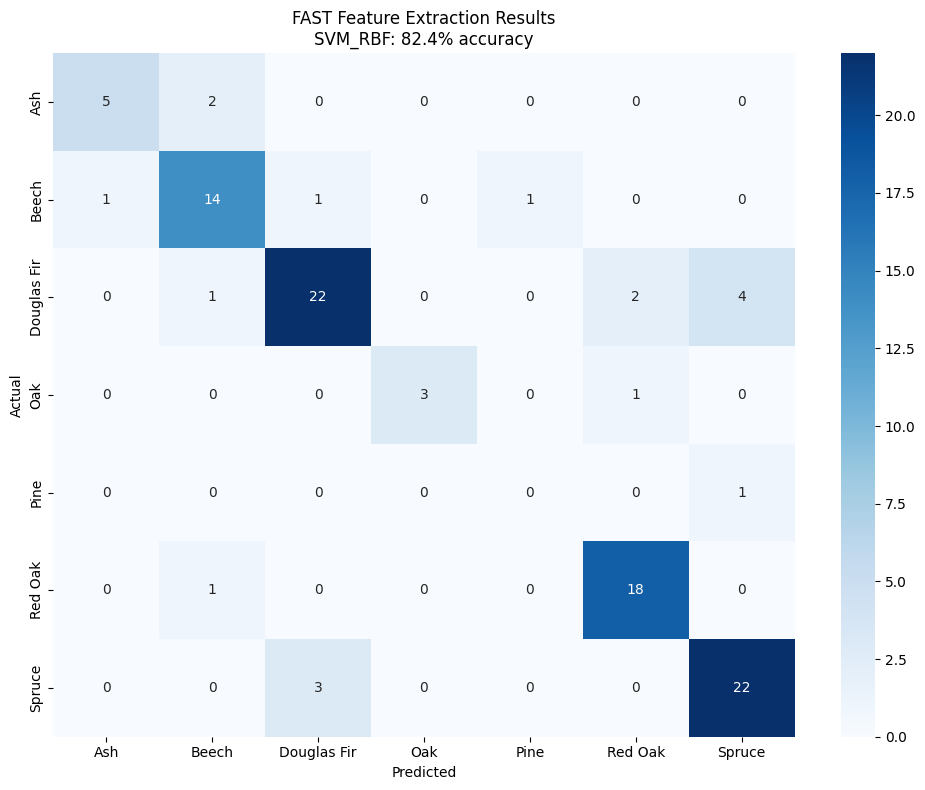


 Model saved: ../../models/fast_feature_extraction_model.joblib
⚡ FAST METHOD COMPLETE!
   Runtime: 36.0s vs 3+ hours
   Accuracy: 82.4%
   Status:  SUCCESS


In [70]:
# FAST Results Analysis
print("📊 FAST FEATURE EXTRACTION RESULTS")
print("="*50)

best_predictions = results[best_name]['predictions']

# Classification report
print(f"Best Model: {best_name}")
print(f"Test Accuracy: {best_score:.3f} ({best_score*100:.1f}%)")
print("\nDetailed Report:")
print(classification_report(test_labels_arr, best_predictions, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels_arr, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'FAST Feature Extraction Results\n{best_name}: {best_score:.1%} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save best model
model_path = f"{MODEL_DIR}/fast_feature_extraction_model.joblib"
joblib.dump({
    'extractor': extractor.state_dict(),
    'classifier': best_classifier,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'class_names': class_names,
    'test_accuracy': best_score,
    'method': 'fast_feature_extraction'
}, model_path)

print(f"\n Model saved: {model_path}")
print(f"⚡ FAST METHOD COMPLETE!")
print(f"   Runtime: {time.time() - start_time:.1f}s vs 3+ hours")
print(f"   Accuracy: {best_score:.1%}")
print(f"   Status: {' SUCCESS' if best_score > 0.6 else 'NEEDS IMPROVEMENT'}")